- (o) target transformation
- (o) group scaling
- interaction term
- feature selection
- outlier detection
- (o) memory reduce
- (o) hour기준 시간대정보: "아침","오후","저녁","밤"
- (o) 기온,강수량,풍속,습도로 파생변수 생성
- (o) 주기성정보: sin_hour, cos_hour
- (x) 전일차이 & rolling mean/std -> test까지 고려해서 넣어야하므로 복잡함
- (o) stacking
- kfold -> timeseries kfold
- (x) lag variable -> 속도만느려지는거같음
- (x) target lag variable -> 성능 매우 안좋아짐
- weiens -> cv추가
- xgb,lgb는 성능이 안좋음 -> 제거
- stacking에서 5개평균으로 넣어보기

# Setting

In [1]:
import sys
sys.path.append('/Volumes/KHJ/Github/hyuckjinkim/lib-python')

In [2]:
from base import gc_collect_all
from data_prepare import (
    get_holiday, reduce_mem_usage, delete_unique_columns,
    TypeController, CategoricalQuantileCalculator,
    GroupScaler, OneHotEncoder, InteractionTerm, TargetTransform,
)

In [3]:
gc_collect_all()

In [4]:
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

import datetime

pd.set_option('mode.chained_assignment',  None)

In [5]:
def global_assignment(dictionary):
    for k,v in dictionary.items():
        exec("globals()['{}']=dictionary['{}']".format(k,k))

In [6]:
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

In [7]:
import numpy as np

class TargetTransfom:
    def __init__(self,transform='identity'):
        assert transform in ['identity','log','sqrt'], \
            print("transform must be one of ['identity','log','sqrt']")
        self.transform = transform
        
    def fit(self,target,verbose=True):
        x = np.array(target)
        if min(x)>0:
            self.offset = 0
        elif min(x)==0:
            self.offset = 1e-3
        else:
            self.offset = -min(x)+1e-3
            if verbose:
                print('minimum = {:.3f}'.format(min(x)))
        #self.offset)return np.log(x+
    
    def transform(self,target):
        x = np.array(target)
        return np.log(x+self.offset)
    
    def fit_transform(self,target,verbose):
        self.fit(self,target,verbose)
        return self.transform(target)

<br></br>

# Configuration

In [8]:
class CFG:
    TARGET = '전력소비량(kWh)'
    SEGMENT = '건물번호'
    
    # feature engineering
    SUBSET_DEPTH = 3
    TARGET_TRANSFORMATION = 'log'#'identity'
    
    # kfold
    SEED = 0
    N_SPLITS = 5

<br></br>

# Data Load

In [25]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')
info_df  = pd.read_csv('./data/building_info.csv')

<br></br>

# EDA

## numeric 1D

(1) 건물번호/건물번호별로 날짜에따른 컬럼 & 타켓 lineplot

In [26]:
def multi_lineplot(data,x,target,columns):
    columns = [col for col in columns if col not in target]
    
    nrow = int(np.ceil(np.sqrt(len(columns))))
    ncol = int(np.ceil(len(columns)/nrow))

    fig = plt.figure(figsize=(20,15))

    for i,col in tqdm(enumerate(columns),total=len(columns)):
        fig.add_subplot(nrow,ncol,i+1)
        ax1 = plt.twinx()
        ax2 = ax1.twinx()
        sns.lineplot(x=date,y=data[col],ax=ax1,color='gray')
        sns.lineplot(x=date,y=data[target],ax=ax2,color='red',alpha=0.5)
        plt.xticks(rotation=45)
        plt.grid()
        plt.title(col,fontsize=20)

    plt.tight_layout()
    plt.show()
    
def make_datetime(yyyy,mm,dd,hh):
    date = str(int(yyyy)) + str(int(mm)).zfill(2) + str(int(dd)).zfill(2) + str(int(hh)).zfill(2)
    date = datetime.datetime.strptime(date,'%Y%m%d%H')
    return date

In [27]:
# group = '건물번호' #'건물유형'
# g_list = train_df3[group].unique()

# i=0
# for g in g_list:
#     i+=1
#     print('\n> [{}/{}] {}: {}'.format(str(i).zfill(len(str(len(g_list)))),len(g_list),group,g))
    
#     d = train_df[train_df[group]==g]
#     d = d.astype({'hour':int})
#     cols = d.columns[d.dtypes!='object'].tolist()
#     cols = [c for c in cols if c not in ['year','month','day','hour']]
    
#     date = [make_datetime(yyyy,mm,dd,hh) for yyyy,mm,dd,hh in d[['year','month','day','hour']].values]
#     multi_lineplot(d,date,CFG.TARGET,cols)

(2) 건물번호/건물번호별로 시간에따른 컬럼 & 타켓 boxplot

In [28]:
# group = '건물번호' #'건물유형'
# g_list = train_df3[group].unique()

# i=0
# for g in g_list:
#     i+=1
#     print('\n> [{}/{}] {}: {}'.format(str(i).zfill(len(str(len(g_list)))),len(g_list),group,g))
    
#     d = train_df[train_df[group]==g]
#     d = d.astype({'hour':int})
#     columns = d.columns[d.dtypes!='object'].tolist()
#     columns = [c for c in columns if c not in ['year','month','day','hour',CFG.TARGET]]

#     nrow = int(np.ceil(np.sqrt(len(columns))))
#     ncol = int(np.ceil(len(columns)/nrow))

#     fig = plt.figure(figsize=(25,20))
#     for i,col in enumerate(columns):
#         fig.add_subplot(nrow,ncol,i+1)
#         ax1 = plt.twinx()
#         ax2 = ax1.twinx()
#         sns.boxplot(x=d['hour'],y=d[CFG.TARGET],ax=ax1)
#         sns.lineplot(x=d['hour'],y=d[col],ax=ax2)
#         plt.title(col,fontsize=20)

#     plt.tight_layout()
#     plt.show()

<br></br>

# Data Preprocess

## Derived Features

In [29]:
# CDH(cooling degree hour, 냉방도일) feature추가
# (참조) https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

In [30]:
def derived_features(data,info):
    d = data.copy()

    # (1) join the building_info
    d = pd.merge(d,info,how='left',on='건물번호')

    if len(d)!=len(data):
        raise ValueError('duplicated after join the building_info')

    # (2) delete the unuse columns
    d.drop('num_date_time',axis=1,inplace=True)

    # (3) 날짜관련 파생변수
    d['일시'] = d['일시'].apply(lambda x: datetime.datetime.strptime(x,'%Y%m%d %H'))
    
    # (3-1) 날짜관련 변수
    d['year']    = d['일시'].dt.year
    d['month']   = d['일시'].dt.month
    d['day']     = d['일시'].dt.day
    d['hour']    = d['일시'].dt.hour
    d['weekday'] = d['일시'].dt.weekday
    d['weekend'] = np.where((d['weekday']==5)|(d['weekday']==6),1,0)
    
    # (3-2) 한국 공휴일
    kr_holidays = get_holiday(d['year'].unique())
    d['is_holiday'] = d['일시'].apply(lambda x: np.where(datetime.datetime.strptime(str(x)[:10],'%Y-%m-%d') in kr_holidays,1,0))
    
    # (3-3) 날짜변수 삭제
    d.drop('일시',axis=1,inplace=True)
    
    # (4) 주기성 정보
    # (참조) https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
    ## cyclic transformation on hour
    d['hour_sin'] = np.sin(2 * np.pi * d['hour']/23.0)
    d['hour_cos'] = np.cos(2 * np.pi * d['hour']/23.0)
    ## cyclic transformation on date 
    d['date_sin'] = -np.sin(2 * np.pi * (d['month']+d['day']/31)/12)
    d['date_cos'] = -np.cos(2 * np.pi * (d['month']+d['day']/31)/12)
    ## cyclic transformation on month
    d['month_sin'] = -np.sin(2 * np.pi * d['month']/12.0)
    d['month_cos'] = -np.cos(2 * np.pi * d['month']/12.0)
    ## cyclic transformation on weekday
    d['weekday_sin'] = -np.sin(2 * np.pi * (d['weekday']+1)/7.0)
    d['weekday_cos'] = -np.cos(2 * np.pi * (d['weekday']+1)/7.0)
    
    # (5) 시간대 정보
    d['time_of_day'] = ['morning'   if  5<=hour<12 else
                        'afternoon' if 12<=hour<17 else
                        'evening'   if 17<=hour<21 else
                        'night' for hour in d['hour']]
    
    # (6) 강수여부
    d['강수량(mm)'].fillna(0,inplace=True)
    d['is_rain'] = np.where(d['강수량(mm)']==0,1,0)
    
    # # 강수량 그룹 : https://namu.wiki/w/%EA%B0%95%EC%9A%B0%EB%9F%89#s-2
    # # -> 그룹이 너무 많아서 제거
    # d['rain_group'] = ['비오지않음' if x<=0 else
    #                    '흩날리는 비' if x<=1 else
    #                    '가늘게 내리는 비' if x<=3 else
    #                    '부슬부슬 내리는 비' if x<=5 else
    #                    '추적추적 내리는 비' if x<=10 else
    #                    '굵은 비' if x<=15 else
    #                    '요란한 비' if x<=20 else
    #                    '장대비' if x<=30 else
    #                    '쏟아붇는 비' if x<=40 else
    #                    '폭우' if x<=50 else
    #                    '집중호우' if x<=70 else
    #                    '자연재해급' for x in d['강수량(mm)']]
    
    # (7) 절대온도, 체감온도, 불쾌지수
    d['기온(F)'] = (d['기온(C)'] * 9/5) + 32
    d['wind_chill'] = 13.12 + 0.6215*d['기온(C)'] - 11.37*(d['풍속(m/s)']**0.16) + 0.3965*d['기온(C)']*(d['풍속(m/s)']**0.16)
    d['discomfort_index'] = (9/5)*d['기온(C)'] - 0.55*(1-d['습도(%)']/100)*((9/5)*d['기온(C)']-26) + 32
    d['discomfort_index_cat'] = pd.cut(d['discomfort_index'],bins=[0,68,75,80,200],labels=[1,2,3,4])\
        .replace('nan',np.nan)
    d['weather_condition'] = ['Hot and Dry'    if (temperature>=30) and (precipitation<1.0) else
                              'Hot and Rainy'  if (temperature>=30) and (precipitation>=1.0) else
                              'Warm and Dry'   if (25<=temperature<30) and (precipitation<1.0) else
                              'Warm and Rainy' if (25<=temperature<30) and (precipitation>=1.0) else
                              'Cool and Dry'   if (temperature<25) and (precipitation<1.0) else
                              'Cool and Rainy' for temperature,precipitation in d[['기온(C)','강수량(mm)']].values]
    
    # (8) CDH(냉방도일) 추가
    cdhs = np.array([])
    for num in d['건물번호'].unique():
        _d = d[d['건물번호']==num]
        cdh = CDH(_d['기온(C)'].values)
        cdhs = np.concatenate([cdhs, cdh])
    d['CDH'] = cdhs
    
    # 컬럼재배열
    key_cols = ['건물번호','year','month','day','hour','weekday','weekend']
    target_col = '전력소비량(kWh)'
    other_cols = [col for col in d.columns if col not in key_cols+[target_col]]
    if target_col in d.columns:
        d = d[key_cols+other_cols+[target_col]]
    else:
        d = d[key_cols+other_cols]

    return d

In [31]:
# (1) info data
# 면적변수(m2) -> sqrt
area_features = ['연면적(m2)','냉방면적(m2)']
for col in area_features:
    info_df[col.replace('m2','m')] = np.sqrt(info_df[col])
    info_df.drop(col,axis=1,inplace=True)

# Null이 많은 컬럼들 제거
null_features = ['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)']
for col in null_features:
    info_df[col] = info_df[col].replace('-','0').astype(float)
    info_df['has_{}'.format(col.split('용량')[0].split('저장')[0])] = np.where(info_df[col]==0,0,1)
# info_df.drop(columns=null_features,inplace=True)

# (2) train/test data
# 건물번호: int to string
train_df['건물번호'] = train_df['건물번호'].astype(str)
test_df ['건물번호'] = test_df ['건물번호'].astype(str)
info_df ['건물번호'] = info_df ['건물번호'].astype(str)

# 파생변수 생성
train_df = derived_features(train_df,info_df)
test_df  = derived_features(test_df ,info_df)

# train에만 있는 컬럼 삭제
train_df.drop(columns=['일조(hr)','일사(MJ/m2)'],inplace=True)

In [32]:
type_controller = TypeController(
    target_feature=CFG.TARGET,
    cat_features=['hour','discomfort_index_cat'],
    unuse_features=['year','month','day'],
    segment_feature=CFG.SEGMENT,
)
type_controller.fit(train_df)
global_assignment(type_controller.get_feature_type())

train_df = type_controller.transform(train_df)
test_df  = type_controller.transform(test_df)

In [33]:
train_df.head()

,건물번호,year,month,day,hour,weekday,weekend,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),연면적(m),냉방면적(m),has_태양광,has_ESS,has_PCS,is_holiday,hour_sin,hour_cos,date_sin,date_cos,month_sin,month_cos,weekday_sin,weekday_cos,time_of_day,is_rain,기온(F),wind_chill,discomfort_index,discomfort_index_cat,weather_condition,CDH,전력소비량(kWh)
0,1,2022,6,1,0,2.0,0,18.6,0.0,0.9,42.0,건물기타,0.0,0.0,0.0,332.616897,198.922095,0,0,0,0.0,0.000000,1.000000,0.016889,0.999857,-1.224647e-16,1.0,-0.433884,0.900969,night,1,65.48,20.751584,63.09388,1,Cool and Dry,-7.4,1085.28
1,1,2022,6,1,1,2.0,0,18.0,0.0,1.1,45.0,건물기타,0.0,0.0,0.0,332.616897,198.922095,0,0,0,0.0,0.269797,0.962917,0.016889,0.999857,-1.224647e-16,1.0,-0.433884,0.900969,night,1,64.40,20.008954,62.46400,1,Cool and Dry,-15.4,1047.36
2,1,2022,6,1,2,2.0,0,17.7,0.0,1.5,45.0,건물기타,0.0,0.0,0.0,332.616897,198.922095,0,0,0,0.0,0.519584,0.854419,0.016889,0.999857,-1.224647e-16,1.0,-0.433884,0.900969,night,1,63.86,19.476910,62.08735,1,Cool and Dry,-23.7,974.88
3,1,2022,6,1,3,2.0,0,16.7,0.0,1.4,48.0,건물기타,0.0,0.0,0.0,332.616897,198.922095,0,0,0,0.0,0.730836,0.682553,0.016889,0.999857,-1.224647e-16,1.0,-0.433884,0.900969,night,1,62.06,18.487958,60.89884,1,Cool and Dry,-33.0,953.76
4,1,2022,6,1,4,2.0,0,18.4,0.0,2.8,43.0,건물기타,0.0,0.0,0.0,332.616897,198.922095,0,0,0,0.0,0.887885,0.460065,0.016889,0.999857,-1.224647e-16,1.0,-0.433884,0.900969,night,1,65.12,19.751534,62.88788,1,Cool and Dry,-40.6,986.40


In [34]:
test_df.head()

,건물번호,year,month,day,hour,weekday,weekend,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),연면적(m),냉방면적(m),has_태양광,has_ESS,has_PCS,is_holiday,hour_sin,hour_cos,date_sin,date_cos,month_sin,month_cos,weekday_sin,weekday_cos,time_of_day,is_rain,기온(F),wind_chill,discomfort_index,discomfort_index_cat,weather_condition,CDH
0,1,2022,8,25,0,3.0,0,23.5,0.0,2.2,72.0,건물기타,0.0,0.0,0.0,332.616897,198.922095,0,0,0,0.0,0.000000,1.000000,0.994869,0.101168,0.866025,0.5,0.433884,0.900969,night,1,74.30,25.397063,71.78980,2,Cool and Dry,-2.5
1,1,2022,8,25,1,3.0,0,23.0,0.0,0.9,72.0,건물기타,0.0,0.0,0.0,332.616897,198.922095,0,0,0,0.0,0.269797,0.962917,0.994869,0.101168,0.866025,0.5,0.433884,0.900969,night,1,73.40,25.201620,71.02840,2,Cool and Dry,-5.5
2,1,2022,8,25,2,3.0,0,22.7,0.0,1.5,75.0,건물기타,0.0,0.0,0.0,332.616897,198.922095,0,0,0,0.0,0.519584,0.854419,0.994869,0.101168,0.866025,0.5,0.433884,0.900969,night,1,72.86,24.699788,70.81675,2,Cool and Dry,-8.8
3,1,2022,8,25,3,3.0,0,22.1,0.0,1.3,78.0,건물기타,0.0,0.0,0.0,332.616897,198.922095,0,0,0,0.0,0.730836,0.682553,0.994869,0.101168,0.866025,0.5,0.433884,0.900969,night,1,71.78,24.136018,70.11262,2,Cool and Dry,-12.7
4,1,2022,8,25,4,3.0,0,21.8,0.0,1.0,77.0,건물기타,0.0,0.0,0.0,332.616897,198.922095,0,0,0,0.0,0.887885,0.460065,0.994869,0.101168,0.866025,0.5,0.433884,0.900969,night,1,71.24,23.942400,69.56514,2,Cool and Dry,-16.9


<br>

## Imputation

In [35]:
def get_null_info(data):
    d = data.copy()
    
    null_info = d\
        .isnull().sum()\
        .reset_index()\
        .rename(columns={'index':'feature',0:'null_cnt'})

    null_info = null_info[null_info['null_cnt']!=0]
    null_info['null_percentage'] = 100 * null_info['null_cnt'] / len(d)

    null_info.sort_values('null_cnt',ascending=False).round(2)
    
    return null_info

In [36]:
get_null_info(train_df)

,feature,null_cnt,null_percentage
9,풍속(m/s),19,0.009314
10,습도(%),9,0.004412
32,wind_chill,19,0.009314
33,discomfort_index,9,0.004412
34,discomfort_index_cat,9,0.004412


In [37]:
from sklearn.impute import SimpleImputer

impute_columns = ['풍속(m/s)','습도(%)']
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
train_df[impute_columns] = imputer.fit_transform(train_df[impute_columns])
test_df [impute_columns] = imputer.transform(test_df[impute_columns])

In [38]:
get_null_info(train_df)

,feature,null_cnt,null_percentage
32,wind_chill,19,0.009314
33,discomfort_index,9,0.004412
34,discomfort_index_cat,9,0.004412


In [40]:
def fix_derived_features(data):
    d = data.copy()
    d['wind_chill'] = 13.12 + 0.6215*d['기온(C)'] - 11.37*(d['풍속(m/s)']**0.16) + 0.3965*d['기온(C)']*(d['풍속(m/s)']**0.16)
    d['discomfort_index'] = (9/5)*d['기온(C)'] - 0.55*(1-d['습도(%)']/100)*((9/5)*d['기온(C)']-26) + 32
    d['discomfort_index_cat'] = pd.cut(d['discomfort_index'],bins=[0,68,75,80,200],labels=[1,2,3,4])\
        .replace('nan',np.nan)
    return d

In [41]:
train_df = fix_derived_features(train_df)
test_df  = fix_derived_features(test_df)

In [42]:
get_null_info(train_df)

,feature,null_cnt,null_percentage


<br>

## Quantile values of Target

In [43]:
# feature engineering
calculator = CategoricalQuantileCalculator()
calculator.fit(
    data=train_df,
    test_data=test_df,
    target_feature=target_feature,
    cat_features=cat_features,
    subset_depth=CFG.SUBSET_DEPTH,
)
train_df2 = calculator.transform(train_df)
test_df2  = calculator.transform(test_df)

> Get quantiles of target by categorical features (depth=3)


Subset: time_of_day + discomfort_index_cat + weather_condition: 100%|██████████| 25/25 [00:06<00:00,  4.00it/s]


In [44]:
type_controller = TypeController(
    target_feature=CFG.TARGET,
    cat_features=['hour','discomfort_index_cat'],
    unuse_features=['year','month','day'],
    segment_feature=CFG.SEGMENT,
)
type_controller.fit(train_df2)
global_assignment(type_controller.get_feature_type())

train_df2 = type_controller.transform(train_df2)
test_df2  = type_controller.transform(test_df2)

In [45]:
print(train_df.shape,'->',train_df2.shape)
train_df2.head()

(204000, 38) -> (204000, 138)


,건물번호,year,month,day,hour,weekday,weekend,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),연면적(m),냉방면적(m),has_태양광,has_ESS,has_PCS,is_holiday,hour_sin,hour_cos,date_sin,date_cos,month_sin,month_cos,weekday_sin,weekday_cos,time_of_day,is_rain,기온(F),wind_chill,discomfort_index,discomfort_index_cat,weather_condition,CDH,전력소비량(kWh),hour_Avg,hour_Q25,hour_Q50,hour_Q75,건물유형_Avg,건물유형_Q25,건물유형_Q50,건물유형_Q75,time_of_day_Avg,time_of_day_Q25,time_of_day_Q50,time_of_day_Q75,discomfort_index_cat_Avg,discomfort_index_cat_Q25,discomfort_index_cat_Q50,discomfort_index_cat_Q75,weather_condition_Avg,weather_condition_Q25,weather_condition_Q50,weather_condition_Q75,hour&건물유형_Avg,hour&건물유형_Q25,hour&건물유형_Q50,hour&건물유형_Q75,hour&time_of_day_Avg,hour&time_of_day_Q25,hour&time_of_day_Q50,hour&time_of_day_Q75,hour&discomfort_index_cat_Avg,hour&discomfort_index_cat_Q25,hour&discomfort_index_cat_Q50,hour&discomfort_index_cat_Q75,hour&weather_condition_Avg,hour&weather_condition_Q25,hour&weather_condition_Q50,hour&weather_condition_Q75,건물유형&time_of_day_Avg,건물유형&time_of_day_Q25,건물유형&time_of_day_Q50,건물유형&time_of_day_Q75,건물유형&discomfort_index_cat_Avg,건물유형&discomfort_index_cat_Q25,건물유형&discomfort_index_cat_Q50,건물유형&discomfort_index_cat_Q75,건물유형&weather_condition_Avg,건물유형&weather_condition_Q25,건물유형&weather_condition_Q50,건물유형&weather_condition_Q75,time_of_day&discomfort_index_cat_Avg,time_of_day&discomfort_index_cat_Q25,time_of_day&discomfort_index_cat_Q50,time_of_day&discomfort_index_cat_Q75,time_of_day&weather_condition_Avg,time_of_day&weather_condition_Q25,time_of_day&weather_condition_Q50,time_of_day&weather_condition_Q75,discomfort_index_cat&weather_condition_Avg,discomfort_index_cat&weather_condition_Q25,discomfort_index_cat&weather_condition_Q50,discomfort_index_cat&weather_condition_Q75,hour&건물유형&time_of_day_Avg,hour&건물유형&time_of_day_Q25,hour&건물유형&time_of_day_Q50,hour&건물유형&time_of_day_Q75,hour&건물유형&discomfort_index_cat_Avg,hour&건물유형&discomfort_index_cat_Q25,hour&건물유형&discomfort_index_cat_Q50,hour&건물유형&discomfort_index_cat_Q75,hour&건물유형&weather_condition_Avg,hour&건물유형&weather_condition_Q25,hour&건물유형&weather_condition_Q50,hour&건물유형&weather_condition_Q75,hour&time_of_day&discomfort_index_cat_Avg,hour&time_of_day&discomfort_index_cat_Q25,hour&time_of_day&discomfort_index_cat_Q50,hour&time_of_day&discomfort_index_cat_Q75,hour&time_of_day&weather_condition_Avg,hour&time_of_day&weather_condition_Q25,hour&time_of_day&weather_condition_Q50,hour&time_of_day&weather_condition_Q75,hour&discomfort_index_cat&weather_condition_Avg,hour&discomfort_index_cat&weather_condition_Q25,hour&discomfort_index_cat&weather_condition_Q50,hour&discomfort_index_cat&weather_condition_Q75,건물유형&time_of_day&discomfort_index_cat_Avg,건물유형&time_of_day&discomfort_index_cat_Q25,건물유형&time_of_day&discomfort_index_cat_Q50,건물유형&time_of_day&discomfort_index_cat_Q75,건물유형&time_of_day&weather_condition_Avg,건물유형&time_of_day&weather_condition_Q25,건물유형&time_of_day&weather_condition_Q50,건물유형&time_of_day&weather_condition_Q75,건물유형&discomfort_index_cat&weather_condition_Avg,건물유형&discomfort_index_cat&weather_condition_Q25,건물유형&discomfort_index_cat&weather_condition_Q50,건물유형&discomfort_index_cat&weather_condition_Q75,time_of_day&discomfort_index_cat&weather_condition_Avg,time_of_day&discomfort_index_cat&weather_condition_Q25,time_of_day&discomfort_index_cat&weather_condition_Q50,time_of_day&discomfort_index_cat&weather_condition_Q75
0,1,2022,6,1,0,2.0,0,18.6,0.0,0.9,42.0,건물기타,0.0,0.0,0.0,332.616897,198.922095,0,0,0,0.0,0.000000,1.000000,0.016889,0.999857,-1.224647e-16,1.0,-0.433884,0.900969,night,1,65.48,20.751584,63.09388,1,Cool and Dry,-7.4,1085.28,1832.909812,739.305,1185.54,2093.0400,1971.725375,1242.33,1732.08,2421.84,1881.151324,807.45,1222.56,2160.48,1818.727305,830.1,1221.66,2124.6,2016.707077,905.76,1361.04,2460.96,1616.129012,1128.12,1376.88,1875.765,1832.909812,739.305,1185.54,2093.0400,1600.232401,652.500,1036.44,1671.730,1709.219183,689.67,1104.84,1929.60,1653.594649,1063.2,1426.

<br>

## Target Transformation

In [46]:
def make_quantile(q):
    return train_df2.groupby(segment_feature)[target_feature].quantile([q]).reset_index().drop('level_1',axis=1).rename(columns={CFG.TARGET:f'q{str(int(100*q))}'})

d = make_quantile(0)\
    .merge(make_quantile(0.25),how='left',on=segment_feature)\
    .merge(make_quantile(0.50),how='left',on=segment_feature)\
    .merge(make_quantile(0.75),how='left',on=segment_feature)\
    .merge(make_quantile(1.00),how='left',on=segment_feature)

# d['건물번호'] = d['건물번호'].astype(float)
d.sort_values(segment_feature).tail(10)

,건물번호,q0,q25,q50,q75,q100
90,90,343.44,480.900,1386.72,2253.720,2824.56
91,91,359.76,478.440,1102.92,2247.000,2699.28
92,92,433.08,581.895,1493.55,1815.975,2129.04
93,93,524.70,877.950,1200.51,1348.245,1532.34
94,94,994.80,1890.900,2478.72,2975.280,3868.80
95,95,0.00,861.480,1072.98,1319.490,2183.76
96,96,1328.52,2224.080,2796.18,3441.180,4379.76
97,97,487.44,973.980,1220.58,1537.335,2021.04
98,98,319.68,773.685,1195.29,1491.030,1946.16
99,99,513.36,785.475,1189.08,1491.840,1973.88


In [47]:
def ffill_outlier(dataset,segment_list):
    data = dataset.copy()
    data_list = []
    for segment in segment_list:
        d = data[data[segment_feature]==segment]
        d[target_feature][d[target_feature]<10] = np.nan
        n_ffill = d[target_feature].isnull().sum()
        if n_ffill!=0:
            print('segment={}: ffill {} values'.format(segment,n_ffill))
        d[target_feature].fillna(method='ffill',inplace=True)
        data_list.append(d)
    return pd.concat(data_list,axis=0).sort_index()

train_df3 = ffill_outlier(train_df2,train_df2[CFG.SEGMENT].unique())
test_df3  = test_df2.copy()

segment=95: ffill 2 values


In [48]:
# tmp = train_df3['전력소비량(kWh)']

# fig = plt.figure(figsize=(20,7))

# fig.add_subplot(121)
# sns.histplot(x=tmp,bins=100,kde=True)
# plt.grid()
# plt.title('(1) No Log')

# fig.add_subplot(122)
# sns.histplot(x=np.log(tmp),bins=100,kde=True)
# plt.grid()
# plt.title('(2) Log')

# plt.tight_layout()
# plt.show()

In [49]:
# segment_list = train_df[segment_feature].unique()
# i=0
# for segment in segment_list:
#     i+=1
#     d = train_df3[train_df3[segment_feature]==segment]
#     tmp = d['전력소비량(kWh)']
#     print('[{}/{}] {}'.format(i,len(segment_list),segment))
    
#     fig = plt.figure(figsize=(20,7))
    
#     fig.add_subplot(121)
#     sns.histplot(x=tmp,bins=100,kde=True)
#     plt.grid()
#     plt.title('(1) No Log')

#     fig.add_subplot(122)
#     sns.histplot(x=np.log(tmp),bins=100,kde=True)
#     plt.grid()
#     plt.title('(2) Log')
    
#     plt.tight_layout()
#     plt.show()

In [50]:
target_transform = TargetTransform(func=CFG.TARGET_TRANSFORMATION)
train_df3['전력소비량(kWh)'] = target_transform.fit_transform(
    target=train_df3['전력소비량(kWh)'],
    verbose=False,
)

<br>

## Group Scaler

In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = GroupScaler(scaler=MinMaxScaler())
scaler.fit(
    data=train_df3,
    segment_feature=segment_feature,
    num_features=num_features,
)
train_df4 = scaler.transform(train_df3)
test_df4  = scaler.transform(test_df3)

[Transform] Segment: 100(100/100): 100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


<br>

## Memory Reduce

In [52]:
train_df5, _ = reduce_mem_usage(train_df4,verbose=True)
test_df5 , _ = reduce_mem_usage(test_df4 ,verbose=False)

[001/132] year: int32 -> uint16
[002/132] month: int32 -> uint8
[003/132] day: int32 -> uint8
[004/132] weekday: float64 -> float32
[005/132] weekend: int64 -> uint8
[006/132] 기온(C): float64 -> float32
[007/132] 강수량(mm): float64 -> float32
[008/132] 풍속(m/s): float64 -> float32
[009/132] 습도(%): float64 -> float32
[010/132] 태양광용량(kW): float64 -> uint8
[011/132] ESS저장용량(kWh): float64 -> uint8
[012/132] PCS용량(kW): float64 -> uint8
[013/132] 연면적(m): float64 -> uint8
[014/132] 냉방면적(m): float64 -> uint8
[015/132] has_태양광: int64 -> uint8
[016/132] has_ESS: int64 -> uint8
[017/132] has_PCS: int64 -> uint8
[018/132] is_holiday: float64 -> uint8
[019/132] hour_sin: float64 -> float32
[020/132] hour_cos: float64 -> float32
[021/132] date_sin: float64 -> float32
[022/132] date_cos: float64 -> float32
[023/132] month_sin: float64 -> float32
[024/132] month_cos: float64 -> float32
[025/132] weekday_sin: float64 -> float32
[026/132] weekday_cos: float64 -> float32
[027/132] is_rain: int64 -> uint8
[02

In [53]:
train_df5.to_parquet('./out/train_df5.parquet')
test_df5 .to_parquet('./out/test_df5.parquet')

<br></br>

# Modeling

## Weighted Ensemble

In [54]:
train_df5 = pd.read_parquet('./out/train_df5.parquet')
test_df5 = pd.read_parquet('./out/test_df5.parquet')

In [55]:
train_fn = train_df5.copy()
test_fn  = test_df5 .copy()

In [56]:
from copy import deepcopy
from sklearn.base import BaseEstimator, RegressorMixin
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
import warnings
import time
import pickle

class WeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,hyperparameters,weight=['equal','balanced'],inverse_transform=None):
        super().__init__()
        
        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"
        
        self.hyperparameters = hyperparameters
        self.weight = weight
        self.inverse_transform = inverse_transform
        self._get_regressors()
    
    def _get_regressors(self):
        max_depth = 9
        n_jobs = -1
        
        params_ridge = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3, 
                                 random_state=self.hyperparameters['random_state']),
        }
        
        params_lasso = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3,
                                 random_state=self.hyperparameters['random_state']),
            'n_jobs' : n_jobs,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_elasticnet = {
            'l1_ratio' : np.arange(0.1, 1, 0.1),
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3,
                                 random_state=self.hyperparameters['random_state']),
            'n_jobs' : n_jobs,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_catboost1 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            #'l2_leaf_reg' : 1,
        }
        
        params_catboost2 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            #'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 3,
        }
        
        params_catboost3 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            'grow_policy' : 'SymmetricTree', # 'Lossguide','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            #'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
        
        params_catboost4 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            'grow_policy' : 'Depthwise', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
    
        params_xgboost = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['xgb_iterations'],
            'early_stopping_rounds' : self.hyperparameters['xgb_early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['xgb_learning_rate'],
            'objective' : 'reg:squarederror',#'reg:absoluteerror',
            'verbosity' : 0,
            'max_depth': self.hyperparameters['max_depth'],
            'n_jobs' : n_jobs,
        }
    
        params_lightgbm = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : 'mean_absolute_error',
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'n_jobs' : n_jobs,
        }
        
        params_extratrees = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['extratrees_iterations'],
            'criterion' : 'absolute_error',
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'n_jobs' : n_jobs,
        }
        
        self.regressors = [
            #LinearRegression(),
            #RidgeCV(**params_ridge),
            #LassoCV(**params_lasso),
            #ElasticNetCV(**params_elasticnet),
            CatBoostRegressor(**params_catboost1),
            CatBoostRegressor(**params_catboost2),
            CatBoostRegressor(**params_catboost3),
            CatBoostRegressor(**params_catboost4),
            #XGBRegressor(**params_xgboost),
            #LGBMRegressor(**params_lightgbm),
            #ExtraTreesRegressor(**params_extratrees),
        ]
        self.regressors_name = [
            #'OLS',
            #'Ridge',
            #'Lasso',
            #'ElasticNet',
            'CatBoost1',
            'CatBoost2',
            'CatBoost3',
            'CatBoost4',
            #'XGBoost',
            #'LightGBM',
            #'ExtraTrees',
        ]
        
    def _set_zero_to_minimum(self,pred,minimum_value):
        pred = np.array(pred).flatten()
        if np.where(pred<0,1,0).sum()>0:
            pred = [x if x>0 else minimum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def _set_inf_to_maximum(self,pred,maximum_value):
        pred = np.array(pred).flatten()
        if np.where(pred==np.inf,1,0).sum()>0:
            pred = [x if x!=np.inf else maximum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def fit(self,X,y,eval_set,oh_set,cat_features,verbose=1):
        assert len(eval_set)==1, \
            "eval_set length must be 1. len(eval_set)={}".format(len(eval_set))
        assert len(oh_set)==1, \
            "oh_set length must be 1. len(oh_set)={}".format(len(oh_set))
        X_val, y_val = eval_set[0]
        X_oh, X_val_oh = oh_set[0]
        
        self.features = X.columns
        self.oh_features = X_oh.columns
        
        tr_true = np.array(y)    .flatten()
        va_true = np.array(y_val).flatten()
        if self.inverse_transform is not None:
            tr_true = self.inverse_transform(tr_true)
            va_true = self.inverse_transform(va_true)
        
        self.minimum_value = min(np.nanmin(y),np.nanmin(y_val))
        self.maximum_value = max(np.nanmax(y),np.nanmax(y_val))
        
        self.cat_features = cat_features
        self.scores = []
        self.weights = []
        self.fitting_elapsed = []
        if verbose:
            pbar = tqdm(zip(self.regressors_name,self.regressors),total=len(self.regressors))
        else:
            pbar = zip(self.regressors_name,self.regressors)
            
        fit_iter = 0
        for regressor_name,regressor in pbar:
            fit_iter+=1
            s = time.time()
            
            if verbose:
                pbar.set_description(name)
                
            if regressor_name in ['OLS','Ridge','Lasso','ElasticNet']:
                warnings.filterwarnings("ignore", category=UserWarning)
                regressor.fit(X_oh,y)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name.find('CatBoost')>=0:
                train_dataset = Pool(X,y,cat_features=cat_features)
                val_dataset   = Pool(X_val,y_val,cat_features=cat_features)
                regressor.fit(
                    train_dataset,
                    eval_set=val_dataset,
                    #metric_period=CFG.EPOCHS//5,
                )
                tr_pred = regressor.predict(train_dataset)
                va_pred = regressor.predict(val_dataset)
            elif regressor_name=='XGBoost':
                regressor.fit(
                    X_oh,y,
                    eval_set=[(X_val_oh,y_val)],
                    verbose=0,
                )
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name=='LightGBM':
                warnings.filterwarnings("ignore", category=UserWarning)
                X_tmp = X.copy()
                X_val_tmp = X_val.copy()
                for col in cat_features:
                    X_tmp[col]     = X_tmp[col]    .astype('category')
                    X_val_tmp[col] = X_val_tmp[col].astype('category')
                regressor.fit(
                    X_tmp,y,
                    eval_set=[(X_val_tmp,y_val)],
                    verbose=-1,
                )
                tr_pred = regressor.predict(X_tmp)
                va_pred = regressor.predict(X_val_tmp)
            elif regressor_name=='ExtraTrees':
                regressor.fit(X_oh,y)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            tr_pred = np.array(tr_pred).flatten()
            va_pred = np.array(va_pred).flatten()
            
            tr_pred = self._set_zero_to_minimum(tr_pred,self.minimum_value)
            va_pred = self._set_zero_to_minimum(va_pred,self.minimum_value)
            
            if self.inverse_transform is not None:
                tr_pred = self.inverse_transform(tr_pred)
                va_pred = self.inverse_transform(va_pred)
                tr_pred = self._set_inf_to_maximum(tr_pred,self.maximum_value)
                va_pred = self._set_inf_to_maximum(va_pred,self.maximum_value)
            
            tr_score = smape(pred=tr_pred,true=tr_true)
            va_score = smape(pred=va_pred,true=va_true)
            e = time.time()
            self.scores.append(va_score)
            self.weights.append(1/va_score)
            self.fitting_elapsed.append(e-s)
            
            blank = ' '*(11-len(regressor_name))
            fit_progress = '[{}/{}] {}{}: loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s'\
                .format(fit_iter,len(self.regressors),regressor_name,blank,tr_score,va_score,e-s)
            print(fit_progress)
        
        if self.weight=='equal':
            self.weights = np.array([1.0 for _ in self.regressors])
        self.weights /= sum(self.weights)
        
        tr_pred = self.predict(X,X_oh)
        va_pred = self.predict(X_val,X_val_oh)
        
        ## -> self.predict에서 inverse_transform 해줌
        # if self.inverse_transform is not None:
        #     tr_pred = self.inverse_transform(tr_pred)
        #     va_pred = self.inverse_transform(va_pred)
        
        ens_tr_score = smape(true=tr_true,pred=tr_pred)
        ens_va_score = smape(true=va_true,pred=va_pred)
        
        ens_fit_progress = "<Weighted Ensemble(weight='{}')> loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s"\
            .format(self.weight,ens_tr_score,ens_va_score,sum(self.fitting_elapsed))
        print(ens_fit_progress)
        
        self.ensemble_score = ens_va_score
        
    def predict(self,X,X_oh):
        assert len(X)==len(X_oh), \
            "X and X_oh must be same length"
        
        pred_list = []
        for regressor_name,regressor in zip(self.regressors_name,self.regressors):
            if regressor_name in ['OLS','Ridge','Lasso','ElasticNet','XGBoost','ExtraTrees']:
                dataset = X_oh.copy()
            elif regressor_name.find('CatBoost')>=0:
                dataset = Pool(X,cat_features=self.cat_features)
            elif regressor_name=='LightGBM':
                dataset = X.copy()
                for col in self.cat_features:
                    dataset[col] = dataset[col].astype('category')
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            y_pred = regressor.predict(dataset)
            y_pred = self._set_zero_to_minimum(y_pred,self.minimum_value)
            
            pred_list.append(y_pred)
            
        final_pred = np.zeros(len(X))
        for pred,weight in zip(pred_list,self.weights):
            final_pred += np.array(pred)*weight
            
        if self.inverse_transform is not None:
            final_pred = self.inverse_transform(np.array(final_pred))
            final_pred = self._set_inf_to_maximum(final_pred,self.maximum_value)
            
        return final_pred
    
    def save_model(self,path):
        save_dict = {
            'cat_features' : self.cat_features,
            'weights' : self.weights,
            'fitting_elapsed' : self.fitting_elapsed,
            'regressors' : self.regressors,
            'minimum_value' : self.minimum_value,
            'maximum_value' : self.maximum_value,
            'features' : self.features,
            'oh_features' : self.oh_features,
            'scores' : self.scores,
            'hyperparameters' : self.hyperparameters,
            'inverse_transform' : self.inverse_transform,
            'ensemble_score' : self.ensemble_score,
        }
        with open(path, 'wb') as f:
            pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_model(self,path):
        with open(path, 'rb') as f:
            save_dict = pickle.load(f)
            self.cat_features = save_dict['cat_features']
            self.weights = save_dict['weights']
            self.fitting_elapsed = save_dict['fitting_elapsed']
            self.regressors = save_dict['regressors']
            self.minimum_value = save_dict['minimum_value']
            self.maximum_value = save_dict['maximum_value']
            self.features = save_dict['features']
            self.oh_features = save_dict['oh_features']
            self.scores = save_dict['scores']
            self.hyperparameters = save_dict['hyperparameters']
            self.inverse_transform = save_dict['inverse_transform']
            self.ensemble_score = save_dict['ensemble_score']

In [57]:
from sklearn.model_selection import KFold

In [58]:
def split_segment(data,segment,seg):
    return data[data[segment]==seg]

In [59]:
hyperparameters = {
    'n_splits' : 5,
    'max_depth' : 9,
    'random_state' : 0,
    'learning_rate' : 0.05,
    'iterations' : 30000,
    'early_stopping_rounds' : 300,
    'xgb_learning_rate' : 0.3,         # default=0.3
    'xgb_iterations' : 3000,           # default=100
    'xgb_early_stopping_rounds' : 30,
    'extratrees_iterations' : 100,     #default=100
}

In [60]:
X      = train_fn.drop(target_feature,axis=1)
X_test = test_fn.copy()
y      = train_fn[target_feature]

ohe = OneHotEncoder()
ohe.fit(X,cat_features)
X_oh      = ohe.transform(X)
X_test_oh = ohe.transform(X_test)

segment_list = X[segment_feature].unique()

  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
> [1/100] Segment: 1, Length: 2040
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] CatBoost1  : loss=0.298, val_loss=4.252, elasped=29.4s
[2/4] CatBoost2  : loss=0.452, val_loss=4.539, elasped=23.7s
[3/4] CatBoost3  : loss=0.476, val_loss=4.164, elasped=18.8s
[4/4] CatBoost4  : loss=0.205, val_loss=4.344, elasped=117.2s
<Weighted Ensemble(weight='balanced')> loss=0.319, val_loss=4.177, elasped=189.0s
> [K-Fold] 2/5
[1/4] CatBoost1  : loss=0.534, val_loss=4.337, elasped=19.0s
[2/4] CatBoost2  : loss=0.245, val_loss=4.511, elasped=39.7s
[3/4] CatBoost3  : loss=0.450, val_loss=4.121, elasped=23.7s
[4/4] CatBoost4  : loss=0.279, val_loss=4.310, elasped=64.4s
<Weighted Ensemble(weight='balanced')> loss=0.325, val_loss=4.217, elasped=146.9s
> [K-Fold] 3/5
[1/4] CatBoost1  : loss=0.357, val_loss=4.660, elasped=25.6s
[2/4] CatBoost2  : loss=0.427, val_loss=4.78

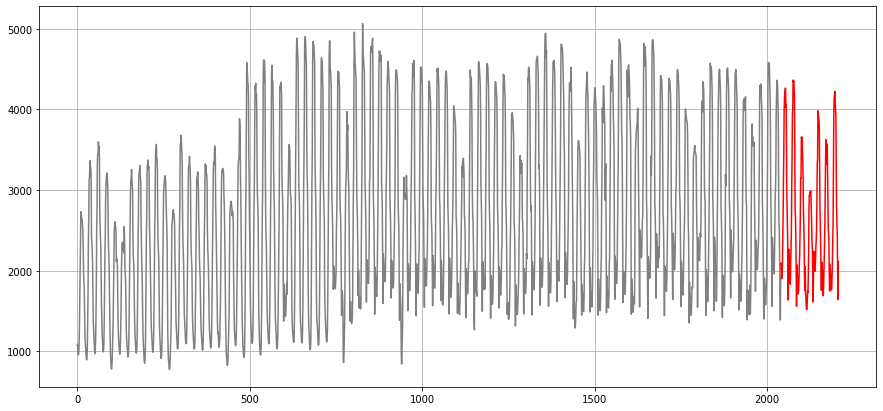

  1%|          | 1/100 [11:11<18:27:35, 671.27s/it]

--------------------------------------------------------------------------------
> [2/100] Segment: 2, Length: 2040
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] CatBoost1  : loss=0.401, val_loss=5.796, elasped=41.6s
[2/4] CatBoost2  : loss=0.613, val_loss=6.119, elasped=30.0s
[3/4] CatBoost3  : loss=1.076, val_loss=5.659, elasped=14.2s
[4/4] CatBoost4  : loss=0.462, val_loss=5.937, elasped=52.0s
<Weighted Ensemble(weight='balanced')> loss=0.577, val_loss=5.746, elasped=137.8s
> [K-Fold] 2/5
[1/4] CatBoost1  : loss=0.575, val_loss=6.600, elasped=23.4s
[2/4] CatBoost2  : loss=0.460, val_loss=6.648, elasped=33.4s
[3/4] CatBoost3  : loss=0.963, val_loss=6.457, elasped=14.5s
[4/4] CatBoost4  : loss=0.280, val_loss=6.468, elasped=91.9s
<Weighted Ensemble(weight='balanced')> loss=0.514, val_loss=6.412, elasped=163.2s
> [K-Fold] 3/5
[1/4] CatBoost1  : loss=0.928, val_loss=6.165, elasped=17.5s
[2/4] CatBoost2  : loss=1.399, val_loss=6.233

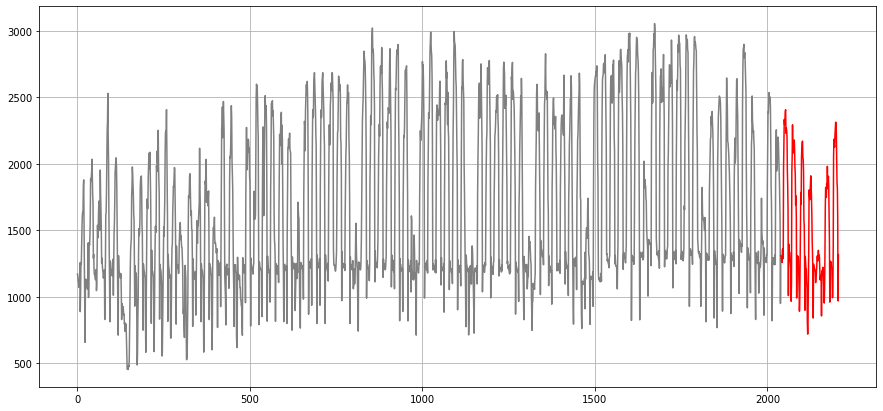

  2%|▏         | 2/100 [23:05<18:57:43, 696.56s/it]

--------------------------------------------------------------------------------
> [3/100] Segment: 3, Length: 2040
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] CatBoost1  : loss=0.363, val_loss=6.733, elasped=75.5s
[2/4] CatBoost2  : loss=0.472, val_loss=6.525, elasped=53.8s
[3/4] CatBoost3  : loss=0.911, val_loss=6.328, elasped=20.7s
[4/4] CatBoost4  : loss=0.467, val_loss=6.953, elasped=95.3s
<Weighted Ensemble(weight='balanced')> loss=0.461, val_loss=6.430, elasped=245.3s
> [K-Fold] 2/5
[1/4] CatBoost1  : loss=0.406, val_loss=6.478, elasped=43.1s
[2/4] CatBoost2  : loss=0.595, val_loss=6.775, elasped=34.3s
[3/4] CatBoost3  : loss=1.209, val_loss=6.472, elasped=12.6s
[4/4] CatBoost4  : loss=0.494, val_loss=6.450, elasped=116.6s
<Weighted Ensemble(weight='balanced')> loss=0.583, val_loss=6.368, elasped=206.6s
> [K-Fold] 3/5
[1/4] CatBoost1  : loss=0.328, val_loss=6.098, elasped=51.1s
[2/4] CatBoost2  : loss=0.405, val_loss=6.28

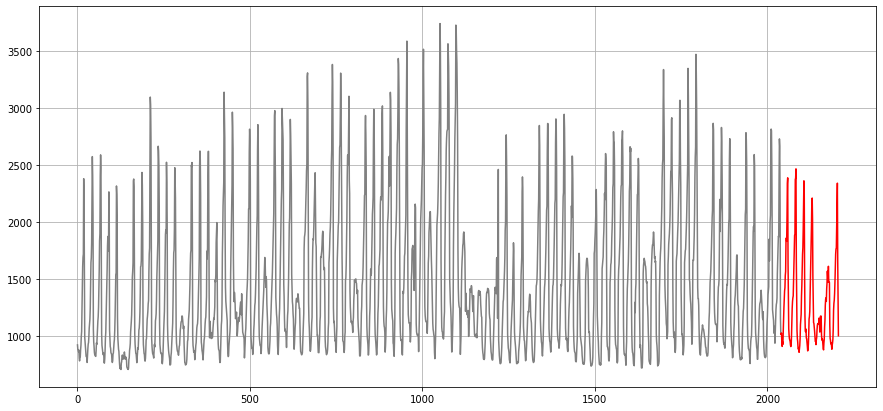

  3%|▎         | 3/100 [38:41<21:42:48, 805.86s/it]

--------------------------------------------------------------------------------
> [4/100] Segment: 4, Length: 2040
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] CatBoost1  : loss=0.353, val_loss=3.108, elasped=18.3s
[2/4] CatBoost2  : loss=0.515, val_loss=3.033, elasped=16.1s
[3/4] CatBoost3  : loss=1.103, val_loss=3.021, elasped=5.3s
[4/4] CatBoost4  : loss=0.176, val_loss=3.200, elasped=47.7s
<Weighted Ensemble(weight='balanced')> loss=0.507, val_loss=3.040, elasped=87.5s
> [K-Fold] 2/5
[1/4] CatBoost1  : loss=0.127, val_loss=2.835, elasped=65.2s
[2/4] CatBoost2  : loss=0.393, val_loss=2.861, elasped=19.2s
[3/4] CatBoost3  : loss=0.311, val_loss=2.805, elasped=30.1s
[4/4] CatBoost4  : loss=0.143, val_loss=2.931, elasped=105.8s
<Weighted Ensemble(weight='balanced')> loss=0.208, val_loss=2.781, elasped=220.3s
> [K-Fold] 3/5
[1/4] CatBoost1  : loss=0.139, val_loss=3.237, elasped=49.9s
[2/4] CatBoost2  : loss=0.327, val_loss=3.320,

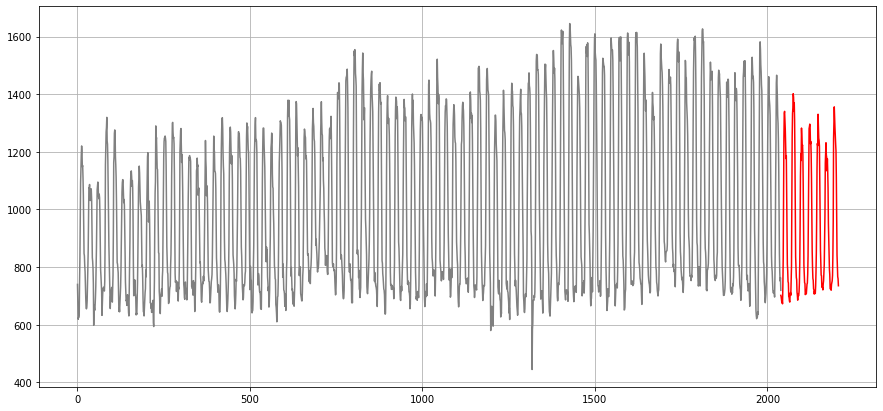

  4%|▍         | 4/100 [50:28<20:26:38, 766.65s/it]

--------------------------------------------------------------------------------
> [5/100] Segment: 5, Length: 2040
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] CatBoost1  : loss=0.423, val_loss=4.833, elasped=69.6s
[2/4] CatBoost2  : loss=0.412, val_loss=5.001, elasped=77.1s
[3/4] CatBoost3  : loss=0.698, val_loss=4.837, elasped=36.1s
[4/4] CatBoost4  : loss=0.408, val_loss=4.953, elasped=84.2s
<Weighted Ensemble(weight='balanced')> loss=0.398, val_loss=4.716, elasped=267.1s
> [K-Fold] 2/5
[1/4] CatBoost1  : loss=0.363, val_loss=4.798, elasped=60.4s
[2/4] CatBoost2  : loss=0.478, val_loss=5.168, elasped=37.8s
[3/4] CatBoost3  : loss=0.649, val_loss=4.411, elasped=28.9s
[4/4] CatBoost4  : loss=0.303, val_loss=4.865, elasped=76.4s
<Weighted Ensemble(weight='balanced')> loss=0.372, val_loss=4.578, elasped=203.6s
> [K-Fold] 3/5
[1/4] CatBoost1  : loss=0.343, val_loss=5.210, elasped=92.0s
[2/4] CatBoost2  : loss=0.518, val_loss=5.444

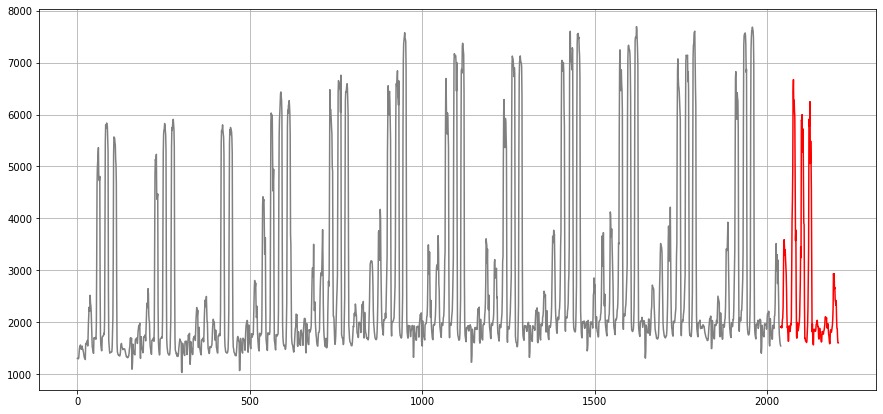

  5%|▌         | 5/100 [1:10:35<24:25:50, 925.80s/it]

--------------------------------------------------------------------------------
> [6/100] Segment: 6, Length: 2040
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] CatBoost1  : loss=0.150, val_loss=2.293, elasped=27.7s
[2/4] CatBoost2  : loss=0.245, val_loss=2.303, elasped=21.1s
[3/4] CatBoost3  : loss=0.270, val_loss=2.184, elasped=16.5s
[4/4] CatBoost4  : loss=0.128, val_loss=2.484, elasped=122.9s
<Weighted Ensemble(weight='balanced')> loss=0.176, val_loss=2.235, elasped=188.1s
> [K-Fold] 2/5
[1/4] CatBoost1  : loss=0.402, val_loss=2.478, elasped=16.1s
[2/4] CatBoost2  : loss=0.355, val_loss=2.479, elasped=18.2s
[3/4] CatBoost3  : loss=0.421, val_loss=2.375, elasped=12.4s
[4/4] CatBoost4  : loss=0.194, val_loss=2.518, elasped=50.0s
<Weighted Ensemble(weight='balanced')> loss=0.313, val_loss=2.383, elasped=96.7s
> [K-Fold] 3/5
[1/4] CatBoost1  : loss=0.110, val_loss=2.376, elasped=55.0s
[2/4] CatBoost2  : loss=0.196, val_loss=2.288

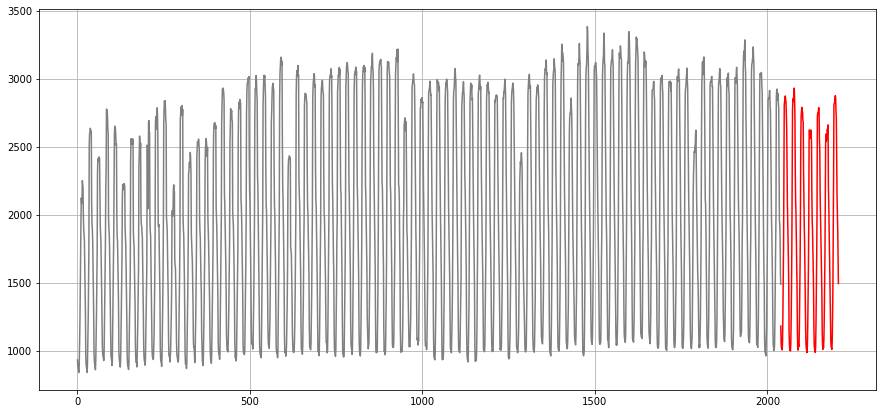

  6%|▌         | 6/100 [1:22:39<22:22:26, 856.88s/it]

--------------------------------------------------------------------------------
> [7/100] Segment: 7, Length: 2040
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] CatBoost1  : loss=0.300, val_loss=4.804, elasped=33.5s
[2/4] CatBoost2  : loss=0.565, val_loss=4.825, elasped=22.7s
[3/4] CatBoost3  : loss=0.687, val_loss=4.739, elasped=22.5s
[4/4] CatBoost4  : loss=0.355, val_loss=4.769, elasped=93.7s
<Weighted Ensemble(weight='balanced')> loss=0.413, val_loss=4.651, elasped=172.4s
> [K-Fold] 2/5
[1/4] CatBoost1  : loss=0.368, val_loss=4.849, elasped=26.7s
[2/4] CatBoost2  : loss=0.541, val_loss=5.097, elasped=23.7s
[3/4] CatBoost3  : loss=0.746, val_loss=4.693, elasped=15.2s
[4/4] CatBoost4  : loss=0.390, val_loss=5.134, elasped=51.0s
<Weighted Ensemble(weight='balanced')> loss=0.459, val_loss=4.807, elasped=116.6s
> [K-Fold] 3/5
[1/4] CatBoost1  : loss=0.317, val_loss=4.616, elasped=33.7s
[2/4] CatBoost2  : loss=0.775, val_loss=4.660

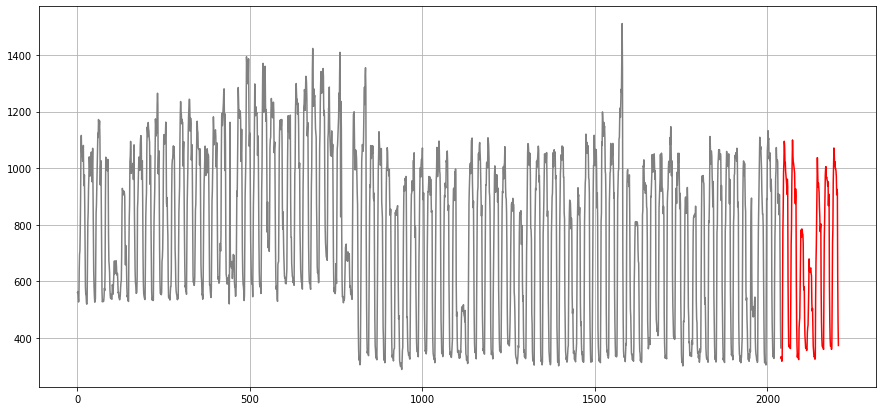

  7%|▋         | 7/100 [1:32:44<20:00:47, 774.71s/it]

--------------------------------------------------------------------------------
> [8/100] Segment: 8, Length: 2040
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] CatBoost1  : loss=0.508, val_loss=3.890, elasped=45.3s
[2/4] CatBoost2  : loss=0.503, val_loss=3.941, elasped=50.8s
[3/4] CatBoost3  : loss=0.879, val_loss=3.827, elasped=19.7s
[4/4] CatBoost4  : loss=0.450, val_loss=3.977, elasped=160.2s
<Weighted Ensemble(weight='balanced')> loss=0.532, val_loss=3.846, elasped=275.9s
> [K-Fold] 2/5
[1/4] CatBoost1  : loss=1.255, val_loss=3.833, elasped=11.5s
[2/4] CatBoost2  : loss=1.119, val_loss=3.819, elasped=13.3s
[3/4] CatBoost3  : loss=1.597, val_loss=3.672, elasped=5.1s
[4/4] CatBoost4  : loss=0.742, val_loss=3.826, elasped=25.2s
<Weighted Ensemble(weight='balanced')> loss=1.142, val_loss=3.718, elasped=55.1s
> [K-Fold] 3/5
[1/4] CatBoost1  : loss=0.517, val_loss=3.656, elasped=22.6s
[2/4] CatBoost2  : loss=1.097, val_loss=3.792,

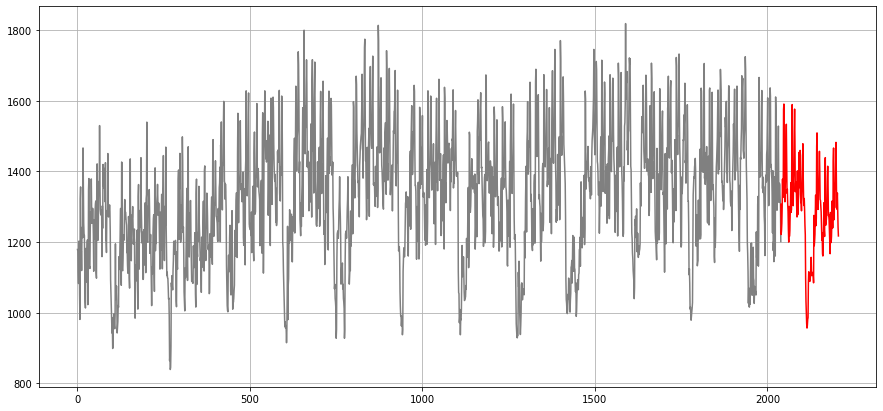

  8%|▊         | 8/100 [1:42:15<18:08:22, 709.80s/it]

--------------------------------------------------------------------------------
> [9/100] Segment: 9, Length: 2040
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] CatBoost1  : loss=0.278, val_loss=2.118, elasped=18.6s
[2/4] CatBoost2  : loss=0.192, val_loss=2.137, elasped=26.7s
[3/4] CatBoost3  : loss=0.297, val_loss=2.104, elasped=15.1s
[4/4] CatBoost4  : loss=0.142, val_loss=2.310, elasped=166.6s
<Weighted Ensemble(weight='balanced')> loss=0.198, val_loss=2.083, elasped=226.9s
> [K-Fold] 2/5
[1/4] CatBoost1  : loss=0.380, val_loss=2.196, elasped=15.5s
[2/4] CatBoost2  : loss=0.332, val_loss=2.223, elasped=17.5s
[3/4] CatBoost3  : loss=0.364, val_loss=2.169, elasped=11.7s
[4/4] CatBoost4  : loss=0.162, val_loss=2.355, elasped=49.9s
<Weighted Ensemble(weight='balanced')> loss=0.285, val_loss=2.169, elasped=94.5s
> [K-Fold] 3/5
[1/4] CatBoost1  : loss=0.148, val_loss=2.236, elasped=35.1s
[2/4] CatBoost2  : loss=0.163, val_loss=2.219

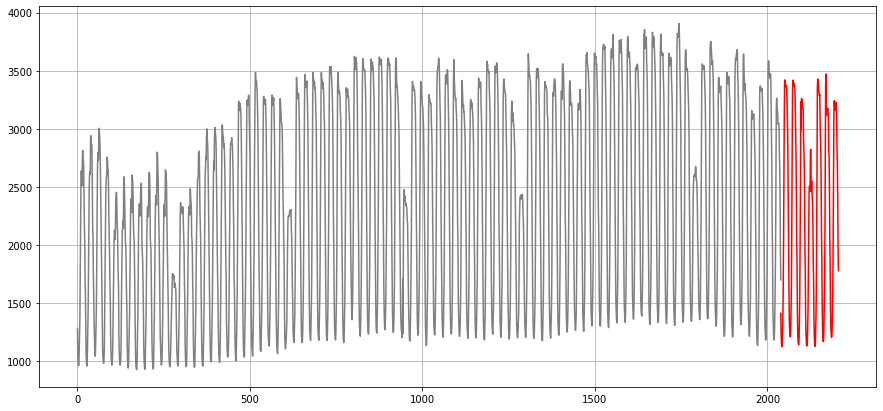

  9%|▉         | 9/100 [1:54:49<18:17:21, 723.53s/it]

--------------------------------------------------------------------------------
> [10/100] Segment: 10, Length: 2040
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] CatBoost1  : loss=0.249, val_loss=2.399, elasped=57.5s
[2/4] CatBoost2  : loss=0.355, val_loss=2.472, elasped=31.0s
[3/4] CatBoost3  : loss=0.480, val_loss=2.377, elasped=32.7s
[4/4] CatBoost4  : loss=0.362, val_loss=2.491, elasped=91.9s
<Weighted Ensemble(weight='balanced')> loss=0.308, val_loss=2.361, elasped=213.1s
> [K-Fold] 2/5
[1/4] CatBoost1  : loss=0.374, val_loss=2.821, elasped=26.2s
[2/4] CatBoost2  : loss=0.380, val_loss=2.838, elasped=26.2s
[3/4] CatBoost3  : loss=0.506, val_loss=2.683, elasped=15.8s
[4/4] CatBoost4  : loss=0.303, val_loss=2.891, elasped=63.3s
<Weighted Ensemble(weight='balanced')> loss=0.341, val_loss=2.741, elasped=131.5s
> [K-Fold] 3/5
[1/4] CatBoost1  : loss=0.228, val_loss=2.490, elasped=67.0s
[2/4] CatBoost2  : loss=0.270, val_loss=2.4

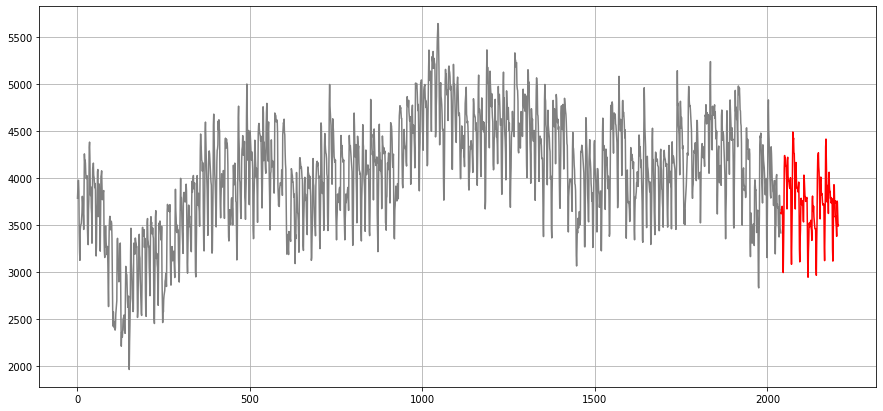

 10%|█         | 10/100 [2:10:05<19:34:45, 783.17s/it]

--------------------------------------------------------------------------------
> [11/100] Segment: 11, Length: 2040
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] CatBoost1  : loss=0.235, val_loss=2.228, elasped=29.5s
[2/4] CatBoost2  : loss=0.922, val_loss=2.317, elasped=8.7s
[3/4] CatBoost3  : loss=0.637, val_loss=2.261, elasped=7.9s
[4/4] CatBoost4  : loss=0.188, val_loss=2.243, elasped=59.6s
<Weighted Ensemble(weight='balanced')> loss=0.452, val_loss=2.199, elasped=105.7s
> [K-Fold] 2/5
[1/4] CatBoost1  : loss=0.947, val_loss=2.614, elasped=8.1s
[2/4] CatBoost2  : loss=1.390, val_loss=2.651, elasped=5.6s
[3/4] CatBoost3  : loss=0.943, val_loss=2.502, elasped=5.0s
[4/4] CatBoost4  : loss=0.175, val_loss=2.781, elasped=39.5s
<Weighted Ensemble(weight='balanced')> loss=0.838, val_loss=2.592, elasped=58.2s
> [K-Fold] 3/5
[1/4] CatBoost1  : loss=1.216, val_loss=2.598, elasped=7.8s
[2/4] CatBoost2  : loss=1.056, val_loss=2.514, ela

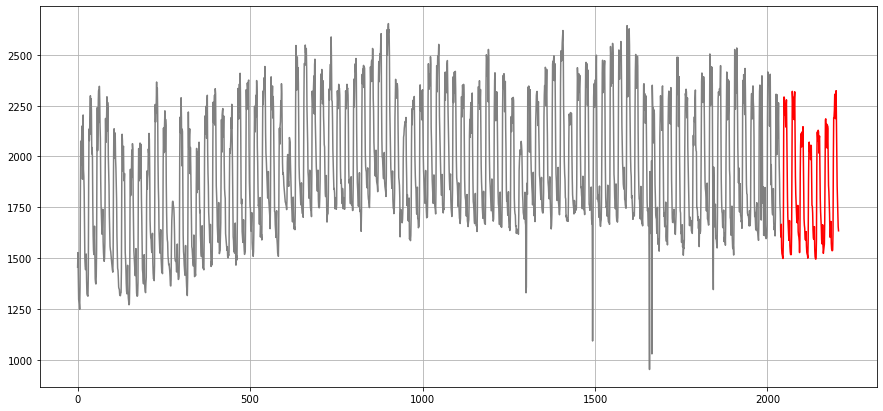

 11%|█         | 11/100 [2:15:53<16:04:02, 649.92s/it]

--------------------------------------------------------------------------------
> [12/100] Segment: 12, Length: 2040
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] CatBoost1  : loss=0.132, val_loss=2.251, elasped=79.8s
[2/4] CatBoost2  : loss=0.207, val_loss=2.285, elasped=32.1s
[3/4] CatBoost3  : loss=0.403, val_loss=2.297, elasped=19.4s
[4/4] CatBoost4  : loss=0.169, val_loss=2.481, elasped=130.2s
<Weighted Ensemble(weight='balanced')> loss=0.197, val_loss=2.259, elasped=261.6s
> [K-Fold] 2/5
[1/4] CatBoost1  : loss=0.275, val_loss=2.323, elasped=21.1s
[2/4] CatBoost2  : loss=0.332, val_loss=2.335, elasped=20.2s
[3/4] CatBoost3  : loss=0.487, val_loss=2.294, elasped=10.4s
[4/4] CatBoost4  : loss=0.163, val_loss=2.612, elasped=50.7s
<Weighted Ensemble(weight='balanced')> loss=0.295, val_loss=2.322, elasped=102.4s
> [K-Fold] 3/5
[1/4] CatBoost1  : loss=0.436, val_loss=2.082, elasped=16.1s
[2/4] CatBoost2  : loss=0.447, val_loss=1.

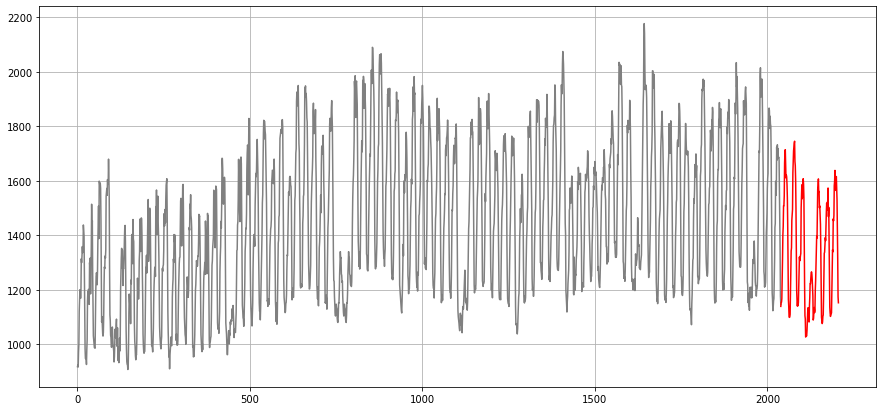

 12%|█▏        | 12/100 [2:30:52<17:44:10, 725.57s/it]

--------------------------------------------------------------------------------
> [13/100] Segment: 13, Length: 2040
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] CatBoost1  : loss=0.199, val_loss=3.555, elasped=92.7s
[2/4] CatBoost2  : loss=0.333, val_loss=3.563, elasped=33.0s
[3/4] CatBoost3  : loss=0.811, val_loss=3.422, elasped=10.3s
[4/4] CatBoost4  : loss=0.303, val_loss=3.538, elasped=110.5s
<Weighted Ensemble(weight='balanced')> loss=0.363, val_loss=3.448, elasped=246.6s
> [K-Fold] 2/5
[1/4] CatBoost1  : loss=0.380, val_loss=3.705, elasped=25.2s
[2/4] CatBoost2  : loss=0.513, val_loss=3.753, elasped=21.4s
[3/4] CatBoost3  : loss=0.633, val_loss=3.560, elasped=14.0s
[4/4] CatBoost4  : loss=0.237, val_loss=3.891, elasped=58.3s
<Weighted Ensemble(weight='balanced')> loss=0.407, val_loss=3.661, elasped=118.9s
> [K-Fold] 3/5
[1/4] CatBoost1  : loss=0.335, val_loss=3.583, elasped=34.7s
[2/4] CatBoost2  : loss=0.320, val_loss=3.

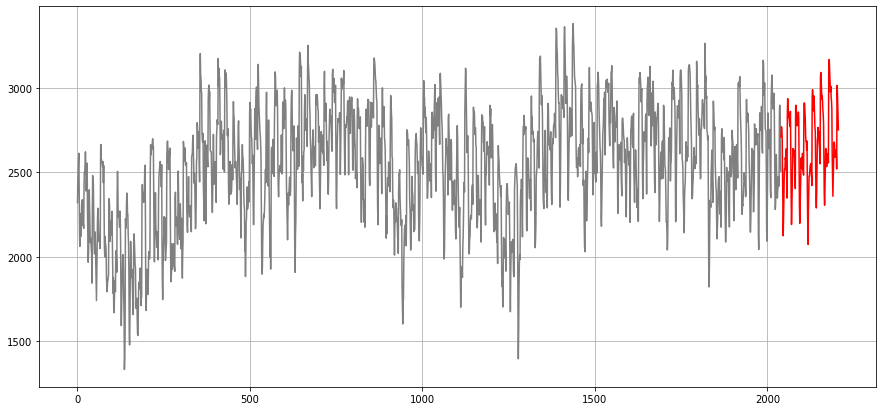

 13%|█▎        | 13/100 [2:47:46<19:38:49, 812.98s/it]

--------------------------------------------------------------------------------
> [14/100] Segment: 14, Length: 2040
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] CatBoost1  : loss=1.082, val_loss=10.435, elasped=34.8s
[2/4] CatBoost2  : loss=1.212, val_loss=10.410, elasped=32.2s
[3/4] CatBoost3  : loss=2.499, val_loss=10.451, elasped=12.8s
[4/4] CatBoost4  : loss=1.109, val_loss=10.589, elasped=60.8s
<Weighted Ensemble(weight='balanced')> loss=1.332, val_loss=10.320, elasped=140.6s
> [K-Fold] 2/5
[1/4] CatBoost1  : loss=1.790, val_loss=10.012, elasped=19.2s
[2/4] CatBoost2  : loss=2.878, val_loss=9.974, elasped=13.7s
[3/4] CatBoost3  : loss=2.438, val_loss=9.751, elasped=15.5s
[4/4] CatBoost4  : loss=1.040, val_loss=10.085, elasped=98.1s
<Weighted Ensemble(weight='balanced')> loss=1.902, val_loss=9.790, elasped=146.6s
> [K-Fold] 3/5
[1/4] CatBoost1  : loss=2.756, val_loss=9.471, elasped=12.9s
[2/4] CatBoost2  : loss=2.247, val_l

 13%|█▎        | 13/100 [2:54:03<19:24:48, 803.32s/it]


KeyboardInterrupt: 

In [62]:
%%time
# 2시간

save_path = './mc/kf_weiens_catall_addvar/segment{}_k{}.pickle'

models = {}
feature_info = {}
scores = []

s_i = 0
for segment in tqdm(segment_list):
    s_i+=1
    gc_collect_all(verbose=False)
    
    # segment에 해당하는 데이터추출
    _X         = split_segment(X        ,segment_feature,segment)
    _X_oh      = split_segment(X_oh     ,segment_feature,segment)
    _X_test    = split_segment(X_test   ,segment_feature,segment)
    _X_test_oh = split_segment(X_test_oh,segment_feature,segment)
    _y         = y[X[segment_feature]==segment]
    
    # kfold
    kf = KFold(n_splits=CFG.N_SPLITS,random_state=1000*s_i+CFG.SEED,shuffle=True)
    
    # unique인 컬럼 제외
    # (1) X
    unique_info = _X.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X = _X.drop(unique_cols,axis=1)
    # (2) X_oh
    unique_info = _X_oh.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X_oh = _X_oh.drop(unique_cols,axis=1)
        
    # categorical feature에서 unique인 컬럼을 제외
    fixed_cat_features = [col for col in cat_features if col in _X.columns]
    
    # progress
    progress = '> [{}/{}] Segment: {}, Length: {}'.format(s_i,len(segment_list),segment,len(_X))
    print('-'*80)
    print(progress)
    print('-'*80)
    
    _models = []
    _scores = []
    k=0
    for tr_idx,val_idx in kf.split(_X,_y):
        k+=1
        print('> [K-Fold] {}/{}'.format(k,CFG.N_SPLITS))
        
        # kfold dataset
        X_tr   , X_va    = _X   .iloc[tr_idx], _X   .iloc[val_idx]
        X_tr_oh, X_va_oh = _X_oh.iloc[tr_idx], _X_oh.iloc[val_idx]
        y_tr   , y_va    = _y   .iloc[tr_idx], _y   .iloc[val_idx]

        # define the model
        ensemble_model = WeightedEnsembleRegressor(
            hyperparameters=hyperparameters,
            weight='balanced',
            inverse_transform=target_transform.inverse_transform,
        )

        # fit the model
        ensemble_model.fit(
            X_tr,y_tr,
            eval_set=[(X_va,y_va)],
            oh_set=[(X_tr_oh,X_va_oh)],
            cat_features=fixed_cat_features,
            verbose=0,
        )

        # save the model
        ensemble_model.save_model(save_path.format(segment,k))

        # prediction
        y_pred = ensemble_model.predict(X_va,X_va_oh).flatten()
        y_true = target_transform.inverse_transform(y_va.values)
        
        # caculate score
        score = mean_absolute_error(y_true=y_true,y_pred=y_pred)
        
        # append inner loop
        _models.append(ensemble_model)
        _scores.append([segment,k,len(X_tr),len(X_va),score])
    
    # kfold result -> plotting
    te_preds = []
    for m in _models:
        te_pred = m.predict(_X_test[X_tr.columns],_X_test_oh[X_tr_oh.columns]).flatten()
        te_preds.append(te_pred)

    te_pred = np.mean(te_preds,axis=0)

    y1 = target_transform.inverse_transform(_y).tolist()
    y2 = te_pred.tolist()

    x1 = range(len(y1))
    x2 = [i+max(x1) for i in range(len(y2))]

    plt.figure(figsize=(15,7))
    sns.lineplot(x=x1,y=y1,color='gray')
    sns.lineplot(x=x2,y=y2,color='red')
    plt.grid()
    plt.show()
        
    # append outer loop
    models[segment] = _models
    scores.append(_scores)
    feature_info[segment] = {
        'cat_features':fixed_cat_features,
        'features':_X.columns.tolist(),
        'oh_features':_X_oh.columns.tolist(),
    }

In [ ]:
score_df = pd.concat([pd.DataFrame(s,columns=['segment','k','n_train','n_val','mae']) for s in scores],axis=0)
score_df

In [ ]:
def load_model(hyperparameters,path):
    ensemble_model = WeightedEnsembleRegressor(
        hyperparameters=hyperparameters,
        weight='balanced',
        inverse_transform=target_transform.inverse_transform,
    )
    ensemble_model.load_model(path)
    return ensemble_model

In [ ]:
X      = train_fn.drop(target_feature,axis=1)
X_test = test_fn.copy()
y      = train_fn[target_feature]

ohe = OneHotEncoder()
ohe.fit(X,cat_features)
X_oh      = ohe.transform(X)
X_test_oh = ohe.transform(X_test)

segment_list = X[segment_feature].unique()

In [ ]:
tr_pred_list = []
te_pred_list = []
for segment in tqdm(segment_list):
    gc_collect_all(verbose=False)
    
    # segment에 해당하는 데이터추출
    _X         = split_segment(X        ,segment_feature,segment)
    _X_oh      = split_segment(X_oh     ,segment_feature,segment)
    _X_test    = split_segment(X_test   ,segment_feature,segment)
    _X_test_oh = split_segment(X_test_oh,segment_feature,segment)
    
    path = './mc/kf_weiens_catall_addvar/segment{}_k{}.pickle'
    model_list = [load_model(hyperparameters,path.format(segment,k)) for k in range(1,6)]
    features = model_list[0].features
    oh_features = model_list[0].oh_features
    _X = _X[features]
    _X_oh = _X_oh[oh_features]
    _X_test = _X_test[features]
    _X_test_oh = _X_test_oh[oh_features]

    tr_pred = np.mean([model.predict(_X,_X_oh) for model in model_list],axis=0)
    tr_pred = pd.DataFrame(tr_pred,index=_X.index)
    tr_pred_list.append(tr_pred)
    
    te_pred = np.mean([model.predict(_X_test[_X.columns],_X_test_oh[_X_oh.columns]) for model in model_list],axis=0)
    te_pred = pd.DataFrame(te_pred,index=_X_test.index)
    te_pred_list.append(te_pred)

In [ ]:
tr_pred_df = pd.concat(tr_pred_list,axis=0).sort_index()
te_pred_df = pd.concat(te_pred_list,axis=0).sort_index()

In [ ]:
smape(pred=tr_pred_df.values.flatten(),true=target_transform.inverse_transform(y))

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['answer'] = te_pred_df.values

In [ ]:
submit.head()

In [ ]:
# public :  (log)
submit.to_csv('./out/20_weiens_seg_catall_addvar.csv',index=False)

<br>

## Stacking

In [ ]:
hyperparameters = {
    'n_splits' : 5,
    'max_depth' : 9,
    'random_state' : 0,
    'learning_rate' : 0.01,
    'iterations' : 30000,
    'early_stopping_rounds' : 300,
    'xgb_learning_rate' : 0.03,         # default=0.3
    'xgb_iterations' : 3000,           # default=100
    'xgb_early_stopping_rounds' : 30,
    'extratrees_iterations' : 100,     #default=100
}

In [ ]:
X      = train_fn.drop(target_feature,axis=1)
X_test = test_fn.copy()
y      = train_fn[target_feature]

ohe = OneHotEncoder()
ohe.fit(X,cat_features)
X_oh      = ohe.transform(X)
X_test_oh = ohe.transform(X_test)

segment_list = X[segment_feature].unique()

In [ ]:
%%time
# 2시간

save_path = './mc/kf_weiens_catall_addvar/stacking_segment{}_k{}.pickle'

stacking_models = {}
stacking_feature_info = {}
stacking_scores = []

s_i = 0
for segment in tqdm(segment_list):
    s_i+=1
    gc_collect_all(verbose=False)
    
    # segment에 해당하는 데이터추출
    _X         = split_segment(X        ,segment_feature,segment)
    _X_oh      = split_segment(X_oh     ,segment_feature,segment)
    _X_test    = split_segment(X_test   ,segment_feature,segment)
    _X_test_oh = split_segment(X_test_oh,segment_feature,segment)
    _y         = y[X[segment_feature]==segment]
    
    path = './mc/kf_weiens_catall_addvar/segment{}_k{}.pickle'
    model_list = [load_model(hyperparameters,path.format(segment,k)) for k in range(1,6)]
    
    features    = model_list[0].features
    oh_features = model_list[0].oh_features
    _X = _X[features]
    _X_oh = _X_oh[oh_features]
    _X_test = _X_test[features]
    _X_test_oh = _X_test_oh[oh_features]
    
    tr_pred = pd.DataFrame(index=_X.index)
    te_pred = pd.DataFrame(index=_X_test.index)
    for i,model in enumerate(model_list,1):
        tr_pred[f'pred{i}'] = model.predict(_X,_X_oh)
        te_pred[f'pred{i}'] = model.predict(_X_test,_X_test_oh)

    _X_new         = pd.concat([_X        ,tr_pred],axis=1)
    _X_oh_new      = pd.concat([_X_oh     ,tr_pred],axis=1)
    _X_test_new    = pd.concat([_X_test   ,te_pred],axis=1)
    _X_test_oh_new = pd.concat([_X_test_oh,te_pred],axis=1)
    
    # categorical feature에서 unique인 컬럼을 제외
    fixed_cat_features = [col for col in cat_features if col in _X_new.columns]
    
    # progress
    progress = '> [{}/{}] Segment: {}, Length: {}'.format(s_i,len(segment_list),segment,len(_X))
    print('-'*80)
    print(progress)
    print('-'*80)
    
    # kfold
    kf = KFold(n_splits=CFG.N_SPLITS,random_state=1000*s_i+CFG.SEED,shuffle=True)
    
    _models = []
    _scores = []
    k=0
    for tr_idx,val_idx in kf.split(_X,_y):
        k+=1
        print('> [K-Fold] {}/{}'.format(k,CFG.N_SPLITS))
        
        # kfold dataset
        X_tr   , X_va    = _X_new   .iloc[tr_idx], _X_new   .iloc[val_idx]
        X_tr_oh, X_va_oh = _X_oh_new.iloc[tr_idx], _X_oh_new.iloc[val_idx]
        y_tr   , y_va    = _y       .iloc[tr_idx], _y       .iloc[val_idx]

        # define the model
        ensemble_model = WeightedEnsembleRegressor(
            hyperparameters=hyperparameters,
            weight='balanced',
            inverse_transform=target_transform.inverse_transform,
        )

        # fit the model
        ensemble_model.fit(
            X_tr,y_tr,
            eval_set=[(X_va,y_va)],
            oh_set=[(X_tr_oh,X_va_oh)],
            cat_features=fixed_cat_features,
            verbose=0,
        )

        # save the model
        ensemble_model.save_model(save_path.format(segment,k))

        # prediction
        y_pred = ensemble_model.predict(X_va,X_va_oh).flatten()
        y_true = target_transform.inverse_transform(y_va.values)
        
        # caculate score
        score = mean_absolute_error(y_true=y_true,y_pred=y_pred)
        
        # append inner loop
        _models.append(ensemble_model)
        _scores.append([segment,k,len(X_tr),len(X_va),score])
    
    # kfold result -> plotting
    te_preds = []
    for m in _models:
        te_pred = m.predict(_X_test_new[X_tr.columns],_X_test_oh_new[X_tr_oh.columns]).flatten()
        te_preds.append(te_pred)

    te_pred = np.mean(te_preds,axis=0)

    y1 = target_transform.inverse_transform(_y).tolist()
    y2 = te_pred.tolist()

    x1 = range(len(y1))
    x2 = [i+max(x1) for i in range(len(y2))]

    plt.figure(figsize=(15,7))
    sns.lineplot(x=x1,y=y1,color='gray')
    sns.lineplot(x=x2,y=y2,color='red')
    plt.grid()
    plt.show()
        
    # append outer loop
    stacking_models[segment] = _models
    stacking_scores.append(_scores)
    stacking_feature_info[segment] = {
        'cat_features':fixed_cat_features,
        'features':_X_new.columns.tolist(),
        'oh_features':_X_oh_new.columns.tolist(),
    }

In [ ]:
score_df = pd.concat([
    pd.DataFrame(s,columns=['segment','k','n_train','n_val','mae']) for s in stacking_scores
],axis=0)
score_df.sort_values('mae',ascending=False).head()

In [ ]:
X      = train_fn.drop(target_feature,axis=1)
X_test = test_fn.copy()
y      = train_fn[target_feature]

ohe = OneHotEncoder()
ohe.fit(X,cat_features)
X_oh      = ohe.transform(X)
X_test_oh = ohe.transform(X_test)

segment_list = X[segment_feature].unique()
for segment in tqdm(segment_list):
    # segment에 해당하는 데이터추출
    _X         = split_segment(X        ,segment_feature,segment)
    _X_oh      = split_segment(X_oh     ,segment_feature,segment)
    _X_test    = split_segment(X_test   ,segment_feature,segment)
    _X_test_oh = split_segment(X_test_oh,segment_feature,segment)
    _y         = y[X[segment_feature]==segment]
    
    path = './mc/kf_weiens_catall_addvar/segment{}_k{}.pickle'
    model_list = [load_model(hyperparameters,path.format(segment,k)) for k in range(1,6)]
    
    features    = model_list[0].features
    oh_features = model_list[0].oh_features
    _X = _X[features]
    _X_oh = _X_oh[oh_features]
    _X_test = _X_test[features]
    _X_test_oh = _X_test_oh[oh_features]
    
    tr_pred = pd.DataFrame(index=_X.index)
    te_pred = pd.DataFrame(index=_X_test.index)
    for i,model in enumerate(model_list,1):
        tr_pred[f'pred{i}'] = model.predict(_X,_X_oh)
        te_pred[f'pred{i}'] = model.predict(_X_test,_X_test_oh)

In [ ]:
tr_pred_list = []
te_pred_list = []
for segment in tqdm(segment_list):
    gc_collect_all(verbose=False)
    
    # segment에 해당하는 데이터추출
    _X         = split_segment(X        ,segment_feature,segment)
    _X_oh      = split_segment(X_oh     ,segment_feature,segment)
    _X_test    = split_segment(X_test   ,segment_feature,segment)
    _X_test_oh = split_segment(X_test_oh,segment_feature,segment)
    
    path = './mc/kf_weiens_catall_addvar/stacking_segment{}_k{}.pickle'
    model_list = [load_model(hyperparameters,path.format(segment,k)) for k in range(1,6)]
    
    org_path = './mc/kf_weiens_catall_addvar/segment{}_k{}.pickle'
    org_model_list = [load_model(hyperparameters,org_path.format(segment,k)) for k in range(1,6)]
    org_features = org_model_list[0].features
    org_oh_features = org_model_list[0].oh_features
    for i,model in enumerate(org_model_list):
        tr_pred_ = model.predict(_X[org_features],_X_oh[org_oh_features])
        _X[f'pred{i+1}']    = tr_pred_
        _X_oh[f'pred{i+1}'] = tr_pred_
        te_pred_ = model.predict(_X_test[org_features],_X_test_oh[org_oh_features])
        _X_test[f'pred{i+1}']    = te_pred_
        _X_test_oh[f'pred{i+1}'] = te_pred_
    
    features = model_list[0].features
    oh_features = model_list[0].oh_features
    
    _X = _X[features]
    _X_oh = _X_oh[oh_features]
    _X_test = _X_test[features]
    _X_test_oh = _X_test_oh[oh_features]

    tr_pred = np.mean([model.predict(_X,_X_oh) for model in model_list],axis=0)
    tr_pred = pd.DataFrame(tr_pred,index=_X.index)
    tr_pred_list.append(tr_pred)
    
    te_pred = np.mean([model.predict(_X_test[_X.columns],_X_test_oh[_X_oh.columns]) for model in model_list],axis=0)
    te_pred = pd.DataFrame(te_pred,index=_X_test.index)
    te_pred_list.append(te_pred)

In [ ]:
tr_pred_df = pd.concat(tr_pred_list,axis=0).sort_index()
te_pred_df = pd.concat(te_pred_list,axis=0).sort_index()

In [ ]:
smape(pred=tr_pred_df.values.flatten(),true=target_transform.inverse_transform(y))

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['answer'] = te_pred_df.values

In [ ]:
submit.head()

In [ ]:
# public :  (log)
submit.to_csv('./out/21_weiens_seg_stacking_catall_addvar.csv',index=False)

In [ ]:
import pandas as pd
a = pd.read_csv('./out/12_weiens_seg_catall.csv')
b = pd.read_csv('./out/13_weiens_seg_stacking_catall.csv')

submit = pd.read_csv('./data/sample_submission.csv')
submit['answer'] = 0.3*a['answer'] + 0.7*b['answer']

In [ ]:
submit.head()

In [ ]:
# public : mean     - 6.1023049459 (log)
# public : 0.3, 0.7 - 6.0998997065 (log)
submit.to_csv('./out/14_weiens_seg_catall_wei_mean(estimators,stacking).csv',index=False)